# Create Ungauged Experiments Gauge Groups

This notebook creates splits of Caravan + GRDC gauges for running models and assessing skill on ungauged basins. 

The splits are:

  1) Random (K-Fold)

  2) Continents

  3) Climate Zones

  4) Countries

# Imports

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
from sklearn.model_selection import KFold

In [4]:
from backend import data_paths
from backend import gauge_groups_utils
from backend import loading_utils
from backend import evaluation_utils

# Experiment Setup

## Create Gauge Groups Directory

In [ ]:
DELETE_EXISTING_GAUGE_GROUPS = False

if os.path.exists(data_paths.GAUGE_GROUPS_DIR) and DELETE_EXISTING_GAUGE_GROUPS:
  raise ValueError('I am making you comment this error and rerun this cell if '
                   'you really want to delete the existing gauge groups.')
  shutil.rmtree(data_paths.GAUGE_GROUPS_DIR)
os.makedirs(data_paths.GAUGE_GROUPS_DIR)

## Load Gauge Groups

In [ ]:
full_gauge_group = gauge_groups_utils.load_gauge_group(data_paths.FULL_GAUGE_GROUP_FILE)
print(f'There are {len(full_gauge_group)} gauges.')

In [ ]:
# The HydroBASINS info file assocaites each gauge with a HydroBASINS polygon.
# We will only keep one gauge per HyBAS level 12 polygon.
with open(data_paths.HYBAS_INFO_FILE, 'r') as f:
  gauges_with_hybas_home_polygon = pd.read_csv(f, index_col='unique_gauge_id')
gauge_to_hybas_id = gauges_with_hybas_home_polygon[['HYBAS_ID']]
print(f'There are {len(set(full_gauge_group) - set(gauge_to_hybas_id.index))} basins missing from the hybas info file.')

gauge_to_hybas_id = gauge_to_hybas_id.loc[full_gauge_group]
gauge_to_hybas_id = gauge_to_hybas_id.loc[gauge_to_hybas_id.drop_duplicates(subset=['HYBAS_ID']).index]
full_gauge_group = list(gauge_to_hybas_id.index)

## Get Lat/Lon

In [7]:
latlon = loading_utils.load_attributes_file(
    attributes=['latitude', 'longitude']
)

## GloFAS Gauge Group

In [ ]:
# Read GloFAS Metadata file.
with open(data_paths.GLOFAS_METADATA_FILE, 'r') as f:
  glofas_metadata = pd.read_csv(f, index_col='Unnamed: 0')
glofas_gauges = glofas_metadata.index

# Find gauge group intersection.
benchmarking_gauges = list(set(full_gauge_group).intersection(glofas_gauges))
print(f'There are {len(benchmarking_gauges)} benchmarking gauges.')

# Plot Record Lengths

In [5]:
record_lengths_df = loading_utils.load_grdc_record_length_file()

,Record Length
Gauge ID,
GRDC_1104150,8.249315
GRDC_1104450,15.668493
GRDC_1104600,9.509589
GRDC_1104800,21.673973
GRDC_1107700,21.271233
...,...
GRDC_6984500,7.002740
GRDC_6984700,7.002740
GRDC_6984800,7.002740


<Axes: title={'center': 'Gauge Locations'}>

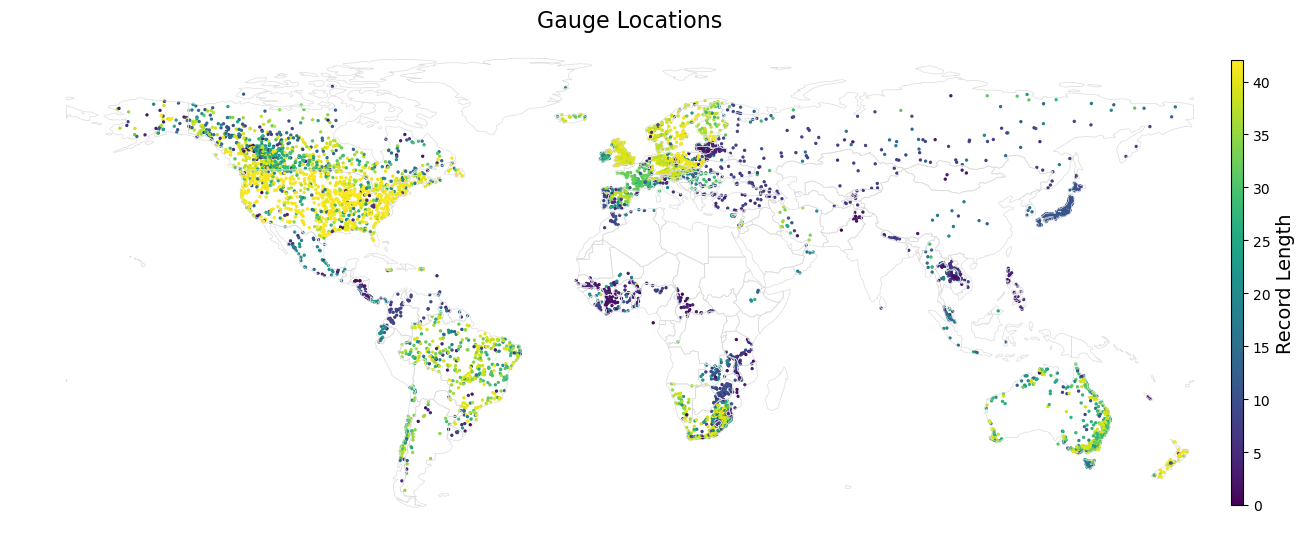

In [16]:
evaluation_utils.spatial_plot(
  record_lengths_df,
  latlon=latlon,
  metric='Record Length',
  vmin=0,
  vmax=42,
  title='Gauge Locations',
  ms=2
)

# Create Random Split Gauge Groups

In [ ]:
KFOLD_GAUGE_GROUPS_DIR = data_paths.GAUGE_GROUPS_DIR / 'kfold_splits' 
os.makedirs(KFOLD_GAUGE_GROUPS_DIR)

In [ ]:
# Store the splits in a DataFrame for plotting later.
random_split_df = gauge_to_hybas_id.copy()
random_split_df = random_split_df.loc[full_gauge_group]

kf = KFold(n_splits=10, random_state=None, shuffle=True)

for split_idx, (_, test_index) in enumerate(kf.split(full_gauge_group)):
  
  # Create the gauge list for this split.
  split_basins = [full_gauge_group[basin_idx] for basin_idx in test_index]

  # Save the list to a file.
  filename = KFOLD_GAUGE_GROUPS_DIR / f'random_group_{split_idx}.txt'
  gauge_groups_utils.write_gauge_group(filename=filename, basins=split_basins)
  
  random_split_df.loc[split_basins, 'split'] = split_idx
  print(f'Saved {len(split_basins)} basins from a random split to ::: {filename}.')

# Create Continent Gague Groups

In [ ]:
CONTINENT_GAUGE_GROUPS_DIR = data_paths.GAUGE_GROUPS_DIR / 'continent_splits' 
os.makedirs(CONTINENT_GAUGE_GROUPS_DIR)

## Map Caravan and GRDC to Continent

In [ ]:
# Mapping from Caravan source dataset to continent.
# This is only needed if the full gauge group includes Caravan gauges.
caravan_continent_mapping = {
    'CAMELS': 'North America',
    'CAMELSAUS': 'South West Pacific',
    'CAMELSBR': 'South America',
    'CAMELSCL': 'South America',
    'CAMELSDK': 'Europe',
    'CAMELSGB': 'Europe',
    'LAMAH': 'Europe',
    'HYSETS': 'North America'
}

def get_caravan_continent(basin):
  source = basin.split('_')[1]
  for source in caravan_continent_mapping:
    if f'_{source}_' in basin:
      return caravan_continent_mapping[source]

gauge_continents_caravan = {basin: get_caravan_continent(basin) for basin in full_gauge_group if 'CARAVAN' in basin} 

In [ ]:
# Maps GRDC gauges to continents.
with open(data_paths.GRDC_METADATA_FILE, 'rt') as f:
  grdc_metadata = pd.read_csv(f, index_col='grdc_no')
  
wmo_region_mapping = {
    1: 'Africa',
    2: 'Asia',
    3: 'South America',
    4: 'North America',
    5: 'South West Pacific',
    6: 'Europe',
}

def get_grdc_continent(basin):
  basin_id = int(basin.split('_')[-1])
  wmo_region = grdc_metadata.loc[basin_id, 'wmo_reg']
  return wmo_region_mapping[wmo_region]

gauge_continents_grdc = {basin: get_grdc_continent(basin) for basin in full_gauge_group if 'GRDC' in basin} 

In [ ]:
# Visual check that the WMO regions are correct.
plt.scatter(grdc_metadata['long'], grdc_metadata['lat'], c=grdc_metadata['wmo_reg'])
cbar = plt.colorbar()
cbar.solids.set_edgecolor("face")

## Save Continent Gauge Groups

In [ ]:
def save_continent_file(continent, basins):
  continent_for_filename = continent.lower().replace(' ', '_')
  filename = CONTINENT_GAUGE_GROUPS_DIR / f'{continent_for_filename}.txt'
  gauge_groups_utils.write_gauge_group(filename=filename, basins=basins)
  return filename

In [ ]:
gauge_continents = {**gauge_continents_grdc, **gauge_continents_caravan}
print(f'There are {len(gauge_continents)} gauges.')

for continent in wmo_region_mapping.values():
  basins_in_continent = [basin for basin, cont in gauge_continents.items() if cont == continent]
  filename = save_continent_file(continent, basins_in_continent)
  print(f'Saved {len(basins_in_continent)} basins in {continent} to ::: {filename}')

# Create Climate Zone Gauge Groups

## Separate into Climate Zones

In [ ]:
# We will get the climate zones from HyBAS attributes.
# First, we need the hybas polygon for each gauge.
gauges_with_hybas_home_polygon = loading_utils.load_hydroatlas_info_file()
gauges_with_hybas_home_polygon = gauges_with_hybas_home_polygon[['longitude',	'latitude', 'unique_gauge_id']]

# Get climate zone from the HyBAS attributes file.
hybas_climate_zones = loading_utils.load_hydroatlas_attributes_file()

# Extract climate zones for gauge group into a df.
climate_zones_df = pd.concat([hybas_climate_zones.loc[gauges_with_hybas_home_polygon.index], gauges_with_hybas_home_polygon], axis=1)
climate_zones_df.reset_index(inplace=True)
climate_zones_df.set_index('unique_gauge_id', inplace=True)
climate_zones_df = climate_zones_df.loc[full_gauge_group]

In [ ]:
# Mapping from integer values in the attributes df to named climate zones.
climate_zone_mapping = {
    1: 'Arctic 1',
    2: 'Arctic 2',
    3: 'Extremely Cold and Wet 1',
    4: 'Extremely Cold and Wet 2',
    5: 'Cold and Wet',
    6: 'Extremely Cold and Mesic',
    7: 'Cold and Mesic',
    8: 'Cool Temperate and Dry',
    9: 'Cool Temperate and Xeric',
    10: 'Cool Temperate and Moist',
    11: 'Warm Temperate and Mesic',
    12: 'Warm Temperate and Xeric',
    13: 'Hot and Mesic',
    14: 'Hot and Dry',
    15: 'Hot and Arid',
    16: 'Extremely Hot and Arid',
    17: 'Extremely Hot and Xeric',
    18: 'Extremely Hot and Moist'
}

# All climate zones.
climate_zones = set(climate_zones_df['clz_cl_smj'])

# Separate basins into all climate zones
basins_in_climate_zone = {}
for zone in climate_zones:
  basins_in_climate_zone[climate_zone_mapping[zone]] = [basin for basin, data in climate_zones_df.iterrows() if data['clz_cl_smj'] == zone]

# Turn the zones into descriptive names.
climate_zones = set([climate_zone_mapping[zone] for zone in climate_zones_df['clz_cl_smj']])

In [ ]:
# Combine certain climate zones without a lot of basins: Cold and Wet.
basins_in_climate_zone['Cold and Wet'] = basins_in_climate_zone['Cold and Wet'] + \
                                         basins_in_climate_zone['Extremely Cold and Wet 1'] + \
                                         basins_in_climate_zone['Extremely Cold and Wet 2']
basins_in_climate_zone.pop('Extremely Cold and Wet 1')
basins_in_climate_zone.pop('Extremely Cold and Wet 2')

# Combine certain climate zones without a lot of basins: Cold and Mesic.
basins_in_climate_zone['Cold and Mesic'] = basins_in_climate_zone['Extremely Cold and Mesic'] + \
                                           basins_in_climate_zone['Cold and Mesic'] + \
                                           basins_in_climate_zone['Arctic 2']
basins_in_climate_zone.pop('Extremely Cold and Mesic')
basins_in_climate_zone.pop('Arctic 2')

# Revised list of climate zones.
climate_zones = list(basins_in_climate_zone.keys())
print(f'There are {len(climate_zones)} climate zones.')

## Save Climate Gauge Groups

In [ ]:
CLIMATE_ZONES_GAUGE_GROUPS_DIR = data_paths.GAUGE_GROUPS_DIR / 'climate_splits' 
os.makedirs(CLIMATE_ZONES_GAUGE_GROUPS_DIR)

def save_climate_file(zone, basins):
  zone_name = zone.lower().replace(' ', '_')
  filename = CLIMATE_ZONES_GAUGE_GROUPS_DIR / f'{zone_name}.txt'
  gauge_groups_utils.write_gauge_group(
      filename=filename, basins=basins)
  return filename

In [ ]:
for zone in climate_zones:
  filename = save_climate_file(zone, basins_in_climate_zone[zone])
  print(f'Saved {len(basins_in_climate_zone[zone])} basins in zone {zone} to ::: {filename}')

# Create Country Gauge Groups

## Separate into Countries

In [ ]:
COUNTRIES_GAUGE_GROUPS_DIR = data_paths.GAUGE_GROUPS_DIR / 'country_splits' 
os.makedirs(COUNTRIES_GAUGE_GROUPS_DIR)

def save_country_file(country, basins):
  country_string = country.lower()
  country_string = country_string.replace(' ', '_')
  country_string = country_string.replace('\'', '')
  country_string = country_string.replace('ã', 'a')
  country_string = country_string.replace('é', 'e')
  country_string = country_string.replace('í', 'i')
  country_string = country_string.replace('ô', 'o')
  filename = COUNTRIES_GAUGE_GROUPS_DIR / f'{country_string}.txt'
  gauge_groups_utils.write_gauge_group(
      filename=filename, basins=basins)
  return filename

In [ ]:
hydroatlas_countries = loading_utils.load_hydroatlas_country_file()
gauges_with_countries = list(set(gauge_to_hybas_id['HYBAS_ID']).intersection(set(hydroatlas_countries.index)))
gauge_countries = hydroatlas_countries.loc[gauges_with_countries]
gauge_countries = gauge_countries[~gauge_countries.index.duplicated(keep='first')]
gauge_countries = pd.concat([gauge_to_hybas_id.reset_index().set_index('HYBAS_ID'), gauge_countries], axis=1)
gauge_countries.reset_index(inplace=True)
gauge_countries.set_index('unique_gauge_id', inplace=True)
gauge_countries = gauge_countries.drop('index', axis=1)
gauge_countries = gauge_countries.dropna()

## Save Country Gauge Groups

In [ ]:
countries = set(gauge_countries['Country'])
for country in countries:
  basins_in_country = [basin for basin, data in gauge_countries.iterrows() if data['Country'] == country]
  print(country, len(basins_in_country))
  filename = save_country_file(country=country, basins=basins_in_country)

# WMO Basin Splits (GRDC Basins Only)

## Separate into WMO BBs

In [ ]:
def get_wmo_bb_from_gauge_id(gauge: str) -> str:
    gauge_id = gauge.strip('GRDC_')
    wmo_bb = gauge_id[0] + gauge_id[2:4]
    return wmo_bb

wmo_bbs = set([get_wmo_bb_from_gauge_id(gauge) for gauge in full_gauge_group])
print(f'There are {len(wmo_bbs)} WMO BBs.')

## Save BB Gauge Groups

In [ ]:
WMOBB_GAUGE_GROUPS_DIR = data_paths.GAUGE_GROUPS_DIR / 'wmobb_splits' 
os.makedirs(WMOBB_GAUGE_GROUPS_DIR)

for bb in wmo_bbs:
  gauges_in_bb = [gauge for gauge in full_gauge_group if get_wmo_bb_from_gauge_id(gauge)==bb]
  print(bb, len(gauges_in_bb))
  
  # Save the list to a file.
  filename = WMOBB_GAUGE_GROUPS_DIR / f'wmobb_{bb}.txt'
  gauge_groups_utils.write_gauge_group(filename=filename, basins=gauges_in_bb)

# Plot Cross Validation Split Maps

In [ ]:
def show_map_of_classes(
    sample_merged_df: pd.DataFrame,
    attributes: pd.DataFrame, 
    column_name: str, 
    title: str, 
    colorbar: bool, 
    cmap: str,
    metric: str,
    ax: plt.Axes = None
):
  values_for_color = sample_merged_df[column_name].values
  values_for_color_to_color_num = {v: i + 1 for i, v in enumerate(sorted(set(values_for_color)))}
  actual_colors = np.array([values_for_color_to_color_num[x] for x in values_for_color])
  evaluation_utils.spatial_plot(
      sample_merged_df[column_name],
      latlon=attributes,
      metric=metric,
      vmin=0.1,
      vmax=actual_colors.max(),
      title=title,
      colorbar=colorbar,
      cmap=cmap,
      ax=ax
  )

In [ ]:
# fig, axes = plt.subplots(2, 2, figsize=(2*evaluation_utils.LONGITUDE_FIG_SIZE, 2*evaluation_utils.LATITIDE_FIG_SIZE))
fig, axes = plt.subplots(3, 1, figsize=(1*evaluation_utils.LONGITUDE_FIG_SIZE, 3*evaluation_utils.LATITIDE_FIG_SIZE))

# --- Random Splits ------------------------------------------------------------

show_map_of_classes(
    random_split_df,
    latlon,
    column_name='split', 
    title='Random (k-fold) Cross Validation Split', 
    colorbar=False, 
    cmap='tab20',
    metric='split',
    ax=axes[0]
)

# --- Continent Splits ---------------------------------------------------------

continent_to_number = {
    'Africa': 1,
    'Asia': 2,
    'South America': 3,
    'North America': 4,
    'South West Pacific': 5,
    'Europe': 6
}

continent_df = gauge_to_hybas_id.copy()
continent_df = continent_df.loc[gauge_continents.keys()]
continent_df['Continent'] = [gauge_continents[gauge] for gauge in continent_df.index]
continent_df['Continent'] = [continent_to_number[gauge_continents[gauge]] for gauge in continent_df.index]

show_map_of_classes(
    continent_df, 
    latlon.rename(columns={'HYDRO_ATLAS:longitude': 'longitude', 'HYDRO_ATLAS:latitude': 'latitude'}), 
    column_name='Continent', 
    title='Continent Cross Validation Split',
    colorbar=False, 
    cmap='tab20',
    metric='Continent',
    ax=axes[1]
)

# --- Climate Splits -----------------------------------------------------------

climate_zones_df['Climate Zone'] = climate_zones_df['clz_cl_smj'] #[climate_zone_mapping[zone] for zone in climate_zones_df['clz_cl_smj']]
show_map_of_classes(
    climate_zones_df, 
    latlon.rename(columns={'HYDRO_ATLAS:longitude': 'longitude', 'HYDRO_ATLAS:latitude': 'latitude'}), 
    column_name='Climate Zone', 
    title='Climate Zone Cross Validation Split',
    colorbar=False, 
    cmap='tab20',
    metric='Climate Zone',
    ax=axes[2]
)

# # --- Country Splits -----------------------------------------------------------

# country_index_mapping = {
#     country: idx for idx, country in enumerate(set(gauge_countries['Country']))
# }
# gauge_countries['Country ID'] = [country_index_mapping[country] for country in gauge_countries['Country']]

# show_map_of_classes(
#     gauge_countries, 
#     latlon.rename(columns={'HYDRO_ATLAS:longitude': 'longitude', 'HYDRO_ATLAS:latitude': 'latitude'}), 
#     column_name='Country ID', 
#     title='Country Cross Validation Split',
#     colorbar=False, 
#     cmap='tab20',
#     metric='Country ID',
#     ax=axes[1, 1]
# )

# --- Save Figure --------------------------------------------------------------
evaluation_utils.save_figure(data_paths.CROSS_VALIDATION_SPLITS_MAP_FIGURE_FILENAME)